In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
from src.utils import pathsetup, split_by_trials
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from src.worldModels import *
from src.utils import *
from src.run_simulations import *
from src.agents import *
from tqdm.notebook import tqdm

import pickle

%matplotlib inline

%reload_ext autoreload
%autoreload 2


## Simulating a single agent (Fig. 1 schematic)

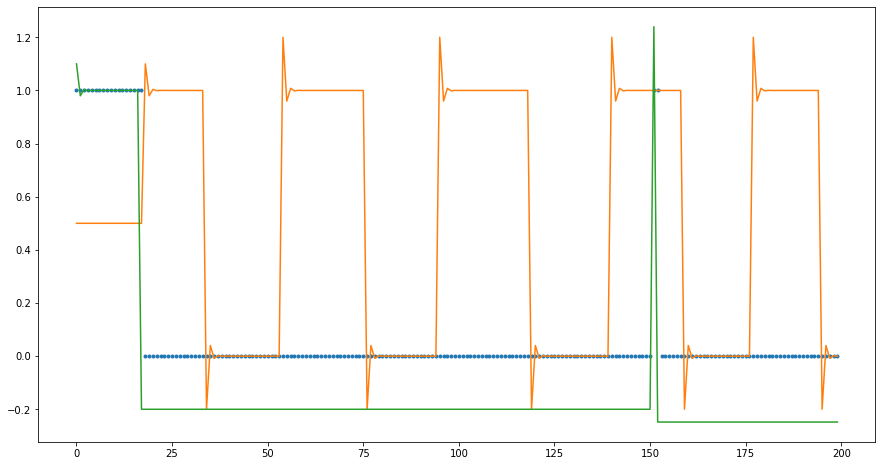

In [2]:
params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=50,
             eps=0, hmm_fit=False, sigmoid_window=30,
             ntrials_per_block=[15, 25], gammalst=[1.2], epslst=[0.01],
             rlow=0, rhigh=1, type='qlearning')

np.random.seed(123)
agent, world, _, _, _ = run_single_agent(0, 0, params)

plt.figure(figsize=(15,8))
plt.plot(agent.choice_history[:200], '.')
plt.plot(agent.q0_history[:200])
plt.plot(agent.q1_history[:200])

paths = pathsetup('matchingsim')
filepath = f"{paths['simdatapath']}/schematic/qlearning-sim-122221.mat"
# if not os.path.exists(filepath):
#     scipy.io.savemat(f"{paths['simdatapath']}/schematic/qlearning-sim-122221.mat", 
#                 dict(choices=agent.choice_history[37:76], q0=agent.q0_history[37:76], 
#                      q1=agent.q1_history[37:76], rewards=agent.outcome_history[37:76],
#                     params=params))
#     print('File saved')
# else:
#     print('Skipping save...')

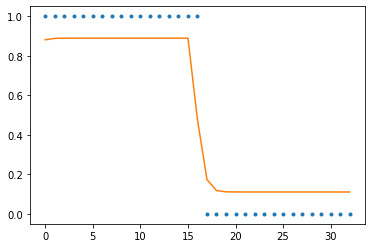

In [3]:
# Inference-based agent
params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=5,
             eps=0, hmm_fit=False, sigmoid_window=30,
             ntrials_per_block=[15, 25], pswitchlst=[0.1], prewlst=[0.9],
             rlow=0, rhigh=1, type='inf-based')

np.random.seed(123)
agent, world, _, _, _ = run_single_agent(0, 0, params)

plt.plot(agent.choice_history[1:34], '.')
plt.plot(agent.p1_history[1:34])

paths = pathsetup('matchingsim')
# scipy.io.savemat(f"{paths['simdatapath']}/schematic/infbased-sim-122221.mat", 
#                 dict(choices=agent.choice_history[1:34], prob0=agent.p0_history[1:34], 
#                      prob1=agent.p1_history[1:34], rewards=agent.outcome_history[1:34],
#                     params=params))

## Simulation of example q-learning and inf-based agents

In [15]:
paths

{'datapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/',
 'codepath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/',
 'blockhmmsimdata': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/simdata/blockhmm',
 'expdatapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/expdata',
 'blockhmmfitpath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/blockhmmfit',
 'simdatapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/simdata',
 'svmdatapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/svm',
 'svmconfigpath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/svm/configs',
 'svmmodelpath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/svm/models',
 'blockhmm_codepath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/blockhmm',


In [26]:
split_by_trials?

In [44]:
# Simulating the behavior of agents along the eps-gamma axis
epslst = [0.1, 0.1, 0.1, 0.5, 0.2, 0.01]
gammalst = [0.1, 0.5, 1.2, 1.2, 1.2, 1.2]

pswitchlst = [0.45, 0.2, 0.01, 0.45, 0.2, 0.01]
prewlst = [0.99, 0.7, 0.55, 0.99, 0.7, 0.55]
simtype = 'qlearning'
Tmax = 6
rlow = 0.1
rhigh = 0.9

choicelst_all = []
params_all = []
pfits = []
coefs_all = []
perf_train_all = []
perf_test_all = []

Niter = 10

np.random.seed(123)
for iteration in range(Niter):
    for i in tqdm(range(len(epslst))):
        if simtype == 'qlearning':
            params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=1000,
                     eps=0, hmm_fit=False, sigmoid_window=30,
                     ntrials_per_block=[15, 25], gammalst=[gammalst[i]], epslst=[epslst[i]],
                     rlow=rlow, rhigh=rhigh, type=simtype)
        elif simtype == 'inf-based':
            params = dict(N_iters=50, num_states=2, obs_dim=1, nblocks=1000,
                     eps=0, hmm_fit=False, sigmoid_window=30,
                     ntrials_per_block=[15, 25], pswitchlst=[pswitchlst[i]], prewlst=[prewlst[i]],
                     rlow=rlow, rhigh=rhigh, type=simtype)

#         np.random.seed(123)

        # Repeated simulation to find error bars for history regression
        agent, world, _, _, _ = run_single_agent(0, 0, params)

        if simtype == 'inf-based':
            filename = f"{paths['simdatapath']}/pitfalls/{simtype}_psw_{pswitchlst[i]}_pr{prewlst[i]}_iter{iteration}.mat"
        else:
            filename = f"{paths['simdatapath']}/pitfalls/{simtype}_gamma_{gammalst[i]}_eps{epslst[i]}_iter{iteration}.mat"

        choicearr = split_by_trials(agent.choice_history, world.ntrialblocks, chop='max')
        outcomearr = split_by_trials(agent.outcome_history, world.ntrialblocks, chop='max')

        # Save the choice, outcomes and target information
        if not os.path.exists(filename):
            scipy.io.savemat(filename, dict(choices=agent.choice_history, outcomes=agent.outcome_history,
                                           rates=world.rate_history, sides=world.side_history,
                                           choicearr=choicearr, outcomearr=outcomearr))
            print('Saved:', filename)
    
    

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

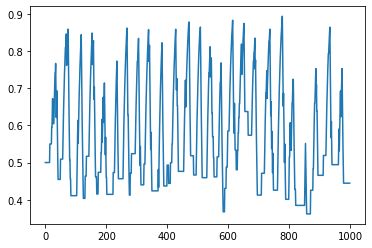

In [37]:
plt.plot(agent.q0_history[:1000])